In [18]:
# Load all libraries

import xarray as xr
import pathlib
from os import listdir
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import gridspec
import matplotlib
import math
import xesmf as xe
import cartopy

In [10]:
SST = xr.open_dataarray('/data/keeling/a/mailes2/a/alt_compset_processed/CESM1_E_TS_piControl.nc')
SST.load()

TAS = xr.open_dataarray('/data/keeling/a/mailes2/a/alt_compset_processed/CESM1_E_TREFHT_piControl.nc')
TAS.load()

surface = xr.open_dataarray('/data/keeling/a/mailes2/a/alt_compset_processed/CESM1_E_Surfacefluxes.nc')
surface.load()

TOA = xr.open_dataarray('/data/keeling/a/mailes2/a/alt_compset_processed/CESM1_E_TOAfluxes.nc')
TOA.load()

horiz = xr.open_dataarray('/data/keeling/a/mailes2/a/alt_compset_processed/CESM1_E_Horizfluxes.nc')
horiz.load()

landmask = xr.open_dataarray('/data/keeling/a/mailes2/a/lens_processed/CESM_LANDFRAC.nc')
landmask.load()

<xarray.DataArray 'LANDFRAC' (lat: 88, lon: 179)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [27]:
def monthlylag_fit(sst_dataset, rad_dataset, datatype='none'):
    """
    Monthly lagged regression
    
    """
    rad_dataset_lag = rad_dataset.shift(time=-1).isel(time=slice(0,10811))
    sst_dataset_lag = sst_dataset.isel(time=slice(0,10811))
    
    # Remove seasonality
    climatology_sst = sst_dataset_lag.groupby('time.month').mean('time')
    sst_anomalies = sst_dataset_lag.groupby('time.month') - climatology_sst
    climatology_rad = rad_dataset_lag.groupby('time.month').mean('time')
    rad_anomalies = rad_dataset_lag.groupby('time.month') - climatology_rad
    
    SST_radfit = xr.DataArray(np.zeros((60,179)), dims=['lat','lon'])
    lat_index = 0
    for lat in rad_dataset_lag.coords['lat'].values:
        lon_index = 0
        for lon in rad_dataset_lag.coords['lon'].values:
            SST_slice = sst_anomalies.sel(lat=lat).sel(lon=lon)
            rad_slice = rad_anomalies.sel(lat=lat).sel(lon=lon)
            idx = np.isfinite(SST_slice) & np.isfinite(rad_slice)
            if not SST_slice[idx].size or not rad_slice[idx].size:                
                SST_radfit[lat_index, lon_index] = np.nan
                lon_index += 1
                continue
            SST_radfit[lat_index, lon_index] = np.polyfit(SST_slice, rad_slice, deg=1)[0]     
            lon_index += 1
        lat_index += 1

    SST_radfit.coords['lon'] = rad_dataset['lon'].values
    SST_radfit.coords['lat'] = rad_dataset['lat'].values
    SST_radfit
    return SST_radfit

# Surface Fluxes

In [4]:
sst_surface_fit = monthlylag_fit(SST,surface)
sst_surface_fit

<xarray.DataArray (lat: 88, lon: 179)>
array([[-0.28920934, -0.28673843, -0.29702989, ..., -0.29172574,
        -0.28452639, -0.28610469],
       [-0.28635513, -0.2972316 , -0.30799463, ..., -0.28124602,
        -0.28560025, -0.28643957],
       [-0.27545359, -0.27567758, -0.28798749, ..., -0.26856735,
        -0.27382875, -0.27004325],
       ...,
       [-0.1068391 , -0.11124265, -0.11473161, ..., -0.08548665,
        -0.08774855, -0.09262433],
       [-0.09856368, -0.09820355, -0.09521839, ..., -0.10172507,
        -0.10358174, -0.09976556],
       [-0.09793693, -0.09903738, -0.10113864, ..., -0.1065306 ,
        -0.10536803, -0.1019424 ]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean SST and Surface Radiation')

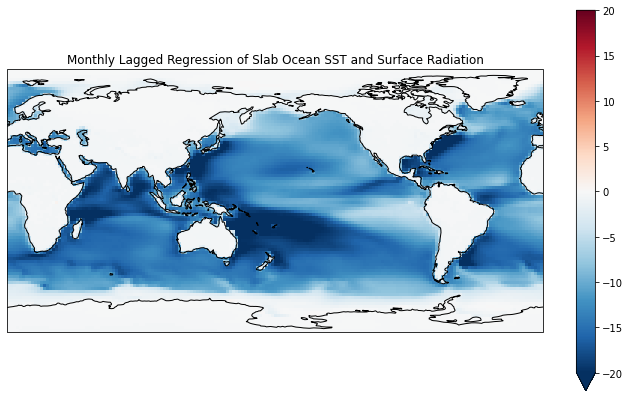

In [9]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean SST and Surface Radiation')

In [5]:
tas_surface_fit = monthlylag_fit(TAS,surface)
tas_surface_fit

<xarray.DataArray (lat: 88, lon: 179)>
array([[-0.29008901, -0.28684571, -0.29661216, ..., -0.29274729,
        -0.28663083, -0.28820533],
       [-0.28838297, -0.29809062, -0.3082453 , ..., -0.28373152,
        -0.28857382, -0.28887174],
       [-0.26661703, -0.26703804, -0.27937147, ..., -0.26008236,
        -0.26507924, -0.26122825],
       ...,
       [-0.104038  , -0.10788921, -0.11073187, ..., -0.08621301,
        -0.08759401, -0.0915146 ],
       [-0.09797758, -0.09724819, -0.09384129, ..., -0.10273434,
        -0.10423287, -0.09979201],
       [-0.09550388, -0.09658618, -0.09862455, ..., -0.10480707,
        -0.10346646, -0.0998277 ]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean TAS and Surface Radiation')

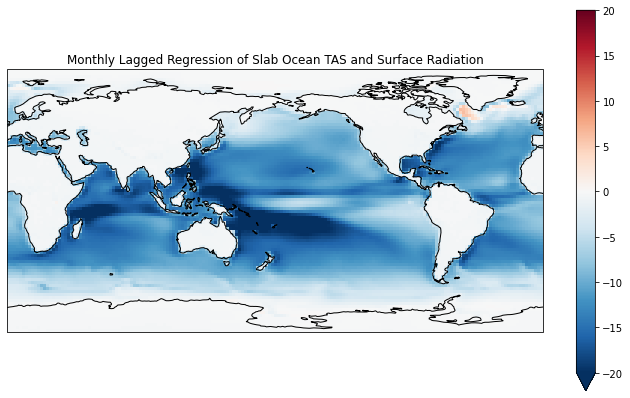

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
tas_surface_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean TAS and Surface Radiation')

# TOA

In [6]:
sst_toa_fit = monthlylag_fit(SST,TOA)
sst_toa_fit

<xarray.DataArray (lat: 88, lon: 179)>
array([[-0.22932998, -0.22420271, -0.2247944 , ..., -0.23275912,
        -0.21698421, -0.22059263],
       [-0.22467632, -0.23582128, -0.23141633, ..., -0.21567224,
        -0.21774567, -0.23000271],
       [-0.21114144, -0.21422772, -0.21111676, ..., -0.20206095,
        -0.20173052, -0.20497664],
       ...,
       [-0.19675236, -0.19431513, -0.19248819, ..., -0.20891468,
        -0.2058856 , -0.20241064],
       [-0.2188331 , -0.21756498, -0.21567495, ..., -0.2254032 ,
        -0.2228915 , -0.22037713],
       [-0.22669592, -0.22549152, -0.22437955, ..., -0.23280217,
        -0.23076294, -0.22909707]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean SST and TOA Radiation')

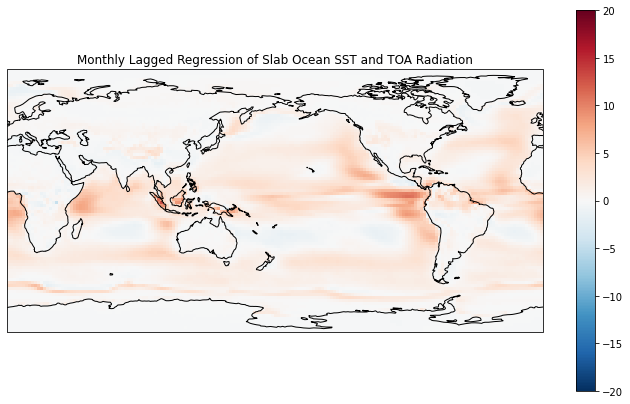

In [5]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean SST and TOA Radiation')

In [ ]:
tas_toa_fit = monthlylag_fit(TAS,TOA)
tas_toa_fit

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean TAS and TOA Radiation')

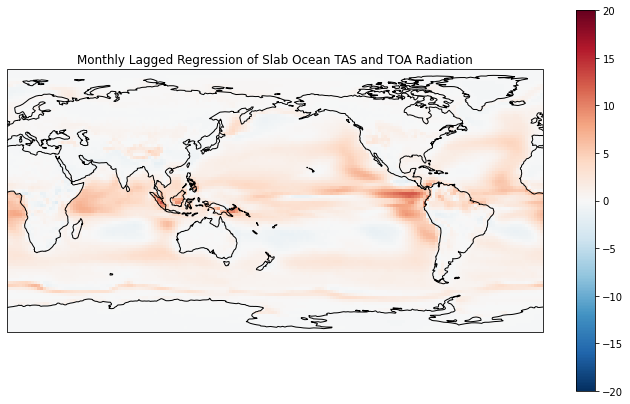

In [7]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
tas_toa_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean TAS and TOA Radiation')

In [8]:
sst_horiz_fit = monthlylag_fit(SST,horiz)
sst_horiz_fit

<xarray.DataArray (lat: 88, lon: 179)>
array([[-0.05987936, -0.06253572, -0.07223549, ..., -0.05896662,
        -0.06754218, -0.06551206],
       [-0.06167882, -0.06141032, -0.07657831, ..., -0.06557378,
        -0.06785457, -0.05643686],
       [-0.06431215, -0.06144987, -0.07687074, ..., -0.06650639,
        -0.07209823, -0.06506661],
       ...,
       [ 0.08991326,  0.08307248,  0.07775658, ...,  0.12342804,
         0.11813705,  0.10978631],
       [ 0.12026942,  0.11936144,  0.12045655, ...,  0.12367813,
         0.11930976,  0.12061158],
       [ 0.12875899,  0.12645414,  0.12324091, ...,  0.12627156,
         0.12539491,  0.12715467]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean SST and Horiz. Radiation')

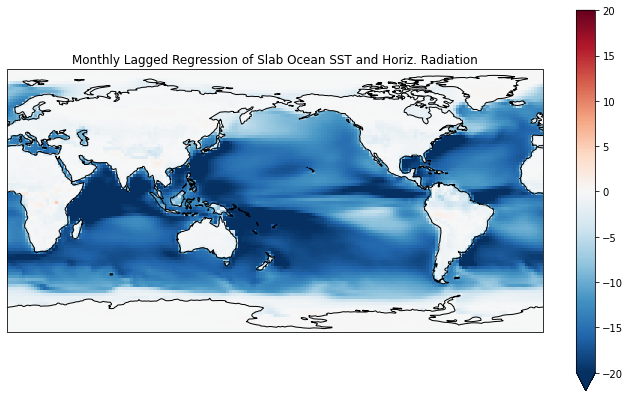

In [5]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean SST and Horiz. Radiation')

In [9]:
tas_horiz_fit = monthlylag_fit(TAS,horiz)
tas_horiz_fit

<xarray.DataArray (lat: 88, lon: 179)>
array([[-0.0703999 , -0.06896074, -0.08121656, ..., -0.06830106,
        -0.07367142, -0.07168749],
       [-0.06303517, -0.06910674, -0.08708605, ..., -0.07263371,
        -0.07136941, -0.06580724],
       [-0.06381005, -0.06145229, -0.07588595, ..., -0.06625208,
        -0.06989678, -0.06487715],
       ...,
       [ 0.09491179,  0.08822558,  0.0832506 , ...,  0.12610382,
         0.12159749,  0.11379419],
       [ 0.12459345,  0.12385303,  0.12513413, ...,  0.12726423,
         0.12308615,  0.12481391],
       [ 0.13454899,  0.13232594,  0.12920981, ...,  0.13144189,
         0.13072428,  0.13259443]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly Lagged Regression of Slab Ocean TAS and Horiz. Radiation')

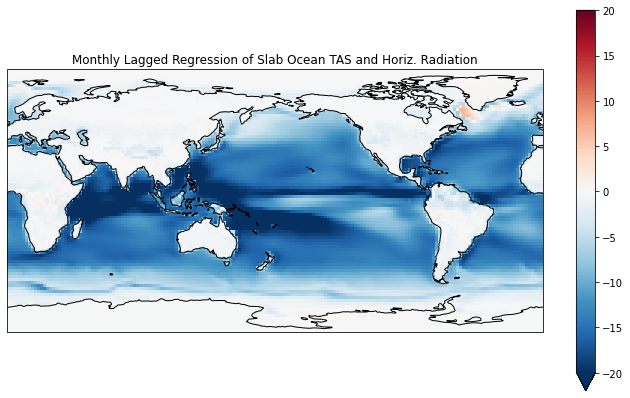

In [7]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
tas_horiz_fit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-20, vmax=20)
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly Lagged Regression of Slab Ocean TAS and Horiz. Radiation')

# Figure for Paper

In [28]:
SST = SST.where(landmask<0.5).sel(lat=slice(-60,60))
surface = surface.sel(lat=slice(-60,60))
surface_sst = surface.where(landmask<0.5)
toa = TOA.sel(lat=slice(-60,60))
toa_sst = toa.where(landmask<0.5)
horiz = horiz.sel(lat=slice(-60,60))
horiz_sst = horiz.where(landmask<0.5)

sst_surface_fit = monthlylag_fit(SST, surface_sst)
tas_surface_fit = monthlylag_fit(TAS, surface)

sst_toa_fit = monthlylag_fit(SST, toa_sst)
tas_toa_fit = monthlylag_fit(TAS, toa)

sst_horiz_fit = monthlylag_fit(SST, horiz_sst)
tas_horiz_fit = monthlylag_fit(TAS, horiz)

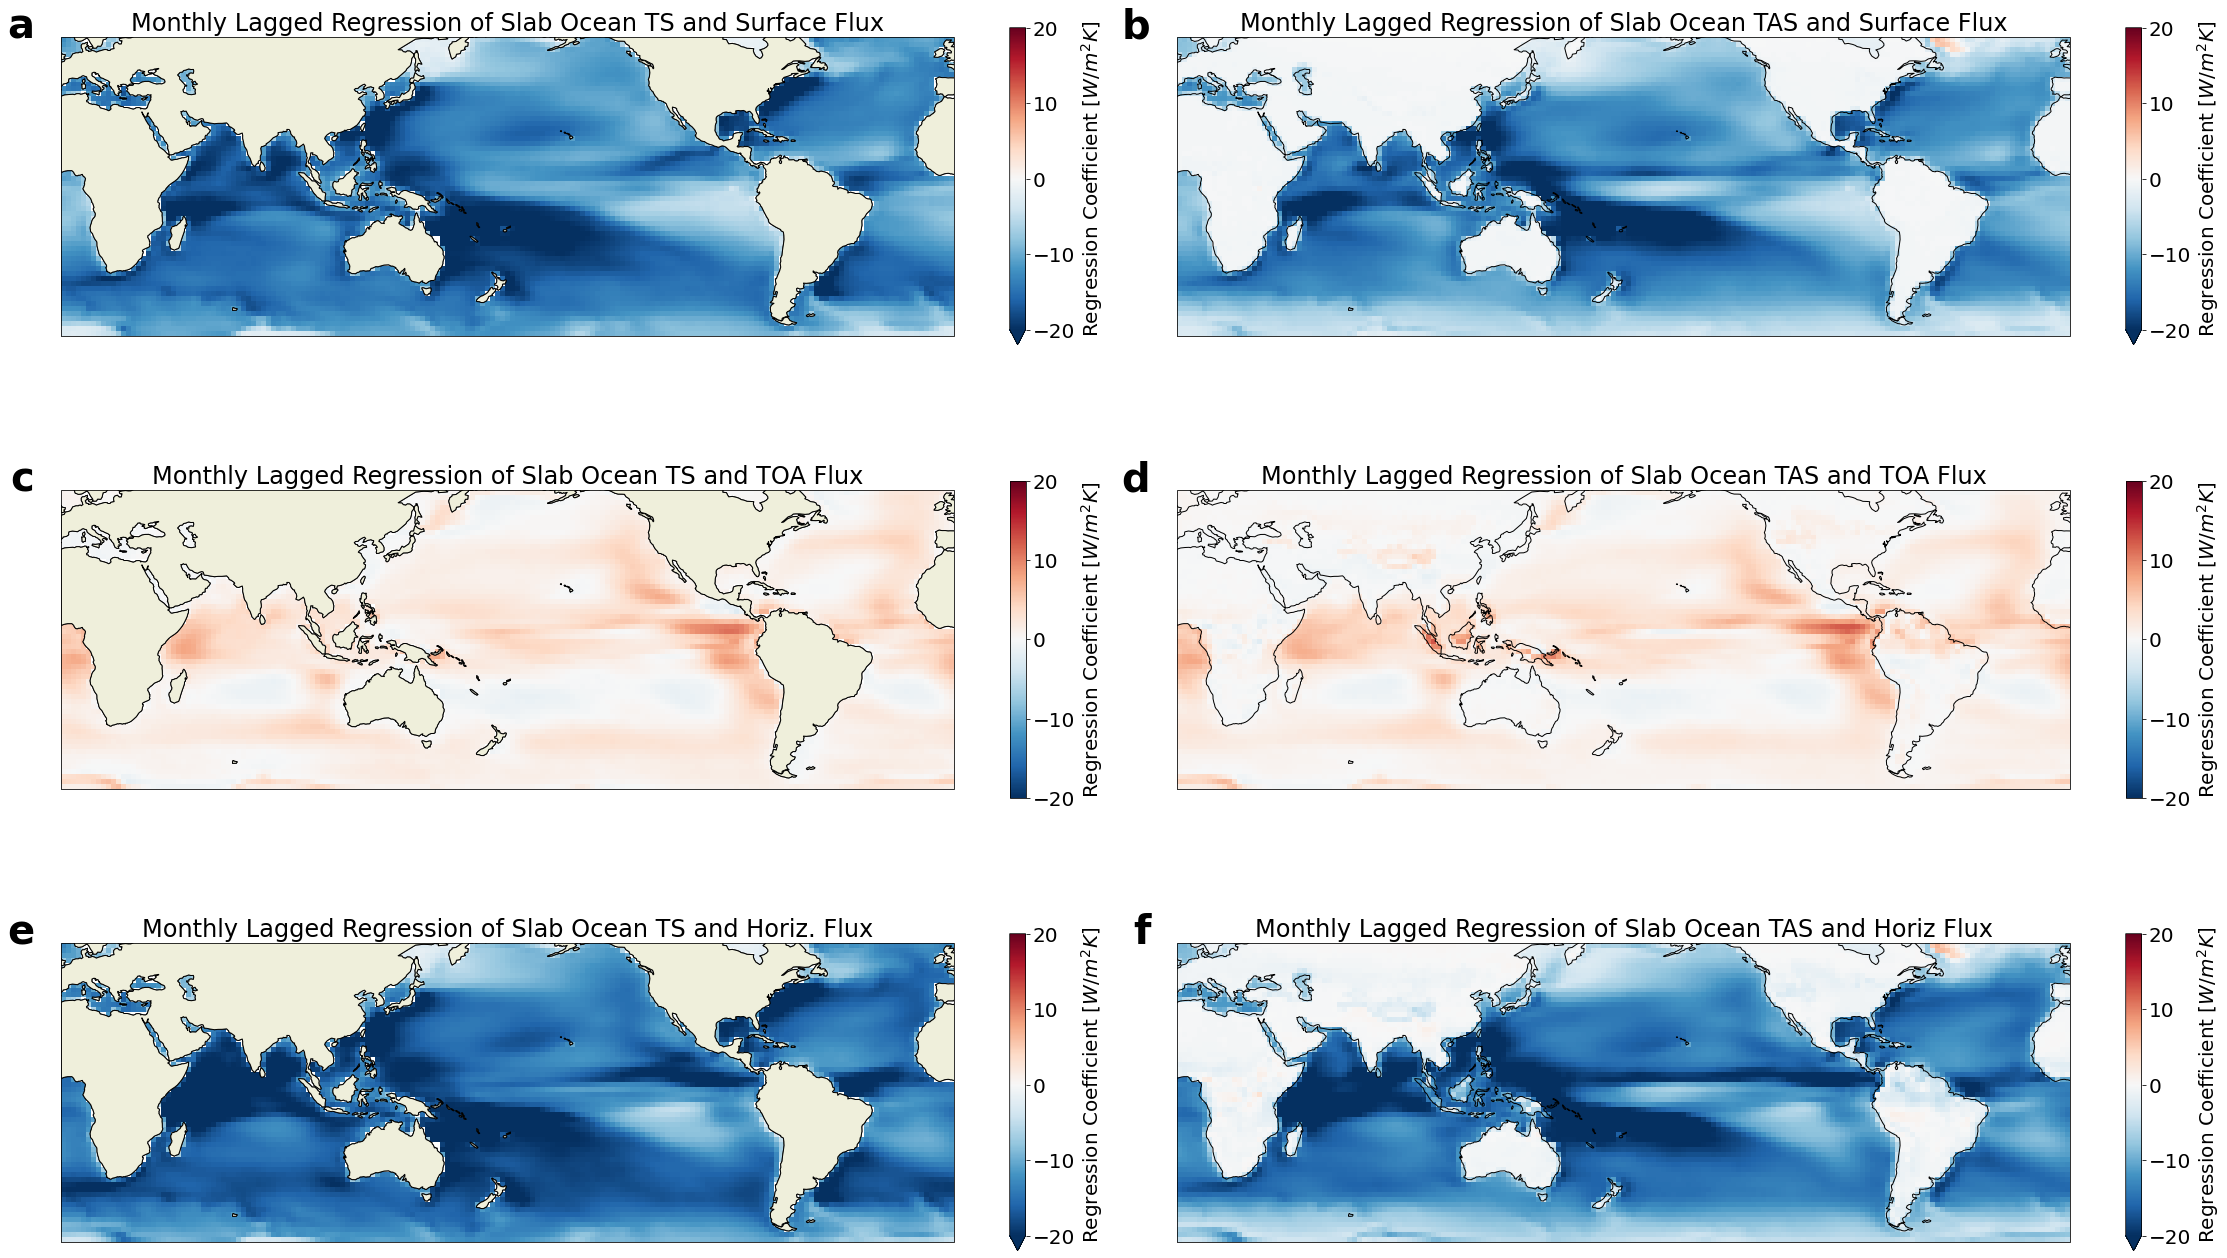

In [41]:
fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=2, nrows=3)
gs.update(wspace=0,hspace=0)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

vmin=-20
vmax=20

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax, 
                     cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax1.set_title('Monthly Lagged Regression of Slab Ocean TS and Surface Flux')
ax1.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k')
ax1.text(-0.03, 1.1, 'a', transform=ax1.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax1.coastlines(color='black', linewidth=1)

ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
tas_surface_fit.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,
                     cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax2.set_title('Monthly Lagged Regression of Slab Ocean TAS and Surface Flux')
ax2.text(-0.03, 1.1, 'b', transform=ax2.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax2.coastlines(color='black', linewidth=1)

ax3 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,
                 cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax3.set_title('Monthly Lagged Regression of Slab Ocean TS and TOA Flux')
ax3.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k')
ax3.text(-0.03, 1.1, 'c', transform=ax3.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax3.coastlines(color='black', linewidth=1)

ax4 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
tas_toa_fit.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,
                 cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax4.set_title('Monthly Lagged Regression of Slab Ocean TAS and TOA Flux')
ax4.text(-0.03, 1.1, 'd', transform=ax4.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax4.coastlines(color='black', linewidth=1)

ax5 = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,
                   cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax5.set_title('Monthly Lagged Regression of Slab Ocean TS and Horiz. Flux')
ax5.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k')
ax5.text(-0.03, 1.1, 'e', transform=ax5.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax5.coastlines(color='black', linewidth=1)

ax6 = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree(central_longitude=180))
tas_horiz_fit.plot(ax=ax6, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,
                   cbar_kwargs={'label': r"Regression Coefficient [$W/m^2K$]",'shrink': 0.7})
ax6.set_title('Monthly Lagged Regression of Slab Ocean TAS and Horiz Flux')
ax6.text(-0.03, 1.1, 'f', transform=ax6.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax6.coastlines(color='black', linewidth=1)
